## Env Setup

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import copy
import tempfile
import seaborn as sns
import random

import datagen as dg
import gerrymandering as gerry
import metrics

## Research Questions


Research Questions: 
1. Is gerrymandering possible on blurred data?
2. If (1): does changing the value of epsilon affect this?
3. TODO

## Data Pipeline Test

In [2]:
pop = int(1e6)
jerries = pop / 2

In [3]:
raw_tree = dg.run_mock_census(2, 4, pop, jerries)

In [4]:
blur_tree = copy.deepcopy(raw_tree)
dg.blur_census_data(blur_tree)

In [5]:
adj_file = '/tmp/adj'
hier_file = '/tmp/hier'
demo_file = '/tmp/demo'

In [6]:
blur_tree.subtree_to_csv(
    adjacency_outfile=adj_file, 
    hierarchy_outfile=hier_file, 
    demographic_outfile=demo_file)

In [7]:
districts = gerry.gerrymander(adj_file, demo_file, hier_file, 2, 'D')

In [8]:
with open(hier_file, 'r') as f: 
    print(f.readlines())

['parent_block,child_block\n', '21,20\n', '20,4\n', '20,3\n', '20,2\n', '20,1\n', '21,19\n', '19,8\n', '19,7\n', '19,6\n', '19,5\n', '21,18\n', '18,12\n', '18,11\n', '18,10\n', '18,9\n', '21,17\n', '17,16\n', '17,15\n', '17,14\n', '17,13\n', '20,4\n', '20,3\n', '20,2\n', '20,1\n', '19,8\n', '19,7\n', '19,6\n', '19,5\n', '18,12\n', '18,11\n', '18,10\n', '18,9\n', '17,16\n', '17,15\n', '17,14\n', '17,13\n']


In [9]:
print(districts)

[{1, 2, 3, 5, 6, 7, 10, 11, 12, 13, 15, 16}, {8, 9, 14}]


In [10]:
efficiency_gap, _ = metrics.efficiency_gap(blur_tree, districts)

In [11]:
print(efficiency_gap)

0.015879341856824547


## Question 1: Is Our Method Effective? 

Suppose our efficiency gap difference between blurred and unblurred is zero. 
Does that mean blurring makes a difference? 
Or does it mean our algorithm sucks and doesn't do anything???

To disambiguate the cases, let's first assess how well our algorithm gerrymanders. 

```
generate raw data.
collect all data into one "giga district" to assess the natural efficiency gap of the data (some biased are impossible to gerrymander into a victory....)
- actually. this is dumb. I should compare this to random districting, instead. 
now, gerrymander.
check the efficiency gap. take the difference from the old efficiency gap. This is our gerrymandering power. 
```

TODO: only get the efficiency gap for democrats, so we don't end up with negative gerrymandering power...

In [12]:
total_pop = 1_000_000
total_democrats = total_pop // 2

num_districts = 10

for _ in range(10): 

    tree = dg.run_mock_census(num_layers=3, fanout=5, total_pop=total_pop, total_jerries=total_democrats)

    all_leaf_ids = set(node.id for node in tree.get_leaf_nodes())
    innate_gap, _ = metrics.efficiency_gap(tree, [all_leaf_ids])

    tree.subtree_to_csv(adjacency_outfile=adj_file, 
                        hierarchy_outfile=hier_file, 
                        demographic_outfile=demo_file)
    districts = gerry.gerrymander(adj_file, demo_file, hier_file, num_districts, 'D')
    improved_gap, _ = metrics.efficiency_gap(tree, districts)

    print(improved_gap, innate_gap)    

0.043297102226646816 0.5
0.1382179396957722 0.5
0.13743998572719618 0.5
0.13595697046286698 0.5
0.12987288181170847 0.5
0.14487414112412741 0.5
0.038586423221075535 0.5
0.1354340846319456 0.5
0.13577526292603856 0.5
0.1442542269646306 0.5


## Question 2: How does Blurring affect our Algorithm's effectiveness? 

In [13]:
total_pop = 1_000_000
total_democrats = total_pop // 2

num_districts = 10

def gen_blurred_tree(tree, epsilon): 
    ret = copy.deepcopy(tree)
    dg.blur_census_data(ret, epsilon)
    return ret

def gerrymander_tree(tree, num_districts): 
    tree.subtree_to_csv(adjacency_outfile=adj_file, 
                        hierarchy_outfile=hier_file, 
                        demographic_outfile=demo_file)
    districts = gerry.gerrymander(adj_file, demo_file, hier_file, num_districts, 'D')
    return districts

def gen_egap_score(tree, epsilon): 
    districts = gerrymander_tree(tree, num_districts)
    egap, _ = metrics.efficiency_gap(tree, districts)
    return egap

runs = {}
for epsilon in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: 
    raw_scores = []
    blurred_scores = []

    for _ in range(25): 
        raw_tree = dg.run_mock_census(num_layers=3, fanout=5, total_pop=total_pop, total_jerries=total_democrats)
        raw_egap = gen_egap_score(raw_tree, epsilon)

        blurred_tree = gen_blurred_tree(raw_tree, epsilon)
        districts = gerrymander_tree(blurred_tree, num_districts)
        # measure how well we obfuscated against the _raw_ data. 
        blurred_egap, _ = metrics.efficiency_gap(raw_tree, districts)

        raw_scores.append(raw_egap)
        blurred_scores.append(blurred_egap)
    runs[str(epsilon)] = { 'raw': raw_scores, 'blurred': blurred_scores }

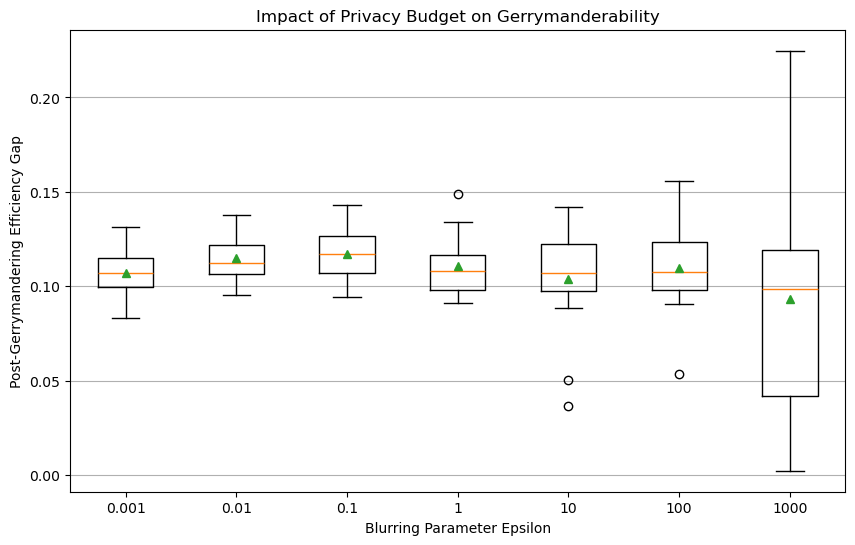

In [14]:
def remove_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return [x for x in data if lower_bound <= x <= upper_bound]

# Prepare data for box plot
epsilons = sorted(runs.keys())  # Ensure sorted order of epsilon
blurred_values = [remove_outliers(runs[epsilon]['blurred']) for epsilon in epsilons]

# Create the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(blurred_values, tick_labels=epsilons, showmeans=True)

# Add labels and title
plt.xlabel('Blurring Parameter Epsilon')
plt.ylabel('Post-Gerrymandering Efficiency Gap')
plt.title('Impact of Privacy Budget on Gerrymanderability')
plt.grid(axis='y')

# Show the plot
plt.savefig('impact-of-epsilon.png', dpi=600)
plt.show()

## Q2: Impact of Number of Output Districts on Results

In [24]:
total_pop = 1_000_000
total_democrats = total_pop // 2
epsilon = 0.01

def gen_blurred_tree(tree, epsilon): 
    ret = copy.deepcopy(tree)
    dg.blur_census_data(ret, epsilon)
    return ret

def gerrymander_tree(tree, num_districts): 
    tree.subtree_to_csv(adjacency_outfile=adj_file, 
                        hierarchy_outfile=hier_file, 
                        demographic_outfile=demo_file)
    districts = gerry.gerrymander(adj_file, demo_file, hier_file, num_districts, 'D')
    return districts

def gen_egap_score(tree, epsilon): 
    districts = gerrymander_tree(tree, num_districts)
    egap, _ = metrics.efficiency_gap(tree, districts)
    return egap

runs = {}
for num_districts in range(2, 10): 
    raw_scores = []
    blurred_scores = []

    for _ in range(25): 
        raw_tree = dg.run_mock_census(num_layers=3, fanout=5, total_pop=total_pop, total_jerries=total_democrats)
        raw_egap = gen_egap_score(raw_tree, epsilon)

        blurred_tree = gen_blurred_tree(raw_tree, epsilon)
        districts = gerrymander_tree(blurred_tree, num_districts)
        # measure how well we obfuscated against the _raw_ data. 
        blurred_egap, _ = metrics.efficiency_gap(raw_tree, districts)

        raw_scores.append(raw_egap)
        blurred_scores.append(blurred_egap)
    runs[num_districts] = { 'raw': raw_scores, 'blurred': blurred_scores }

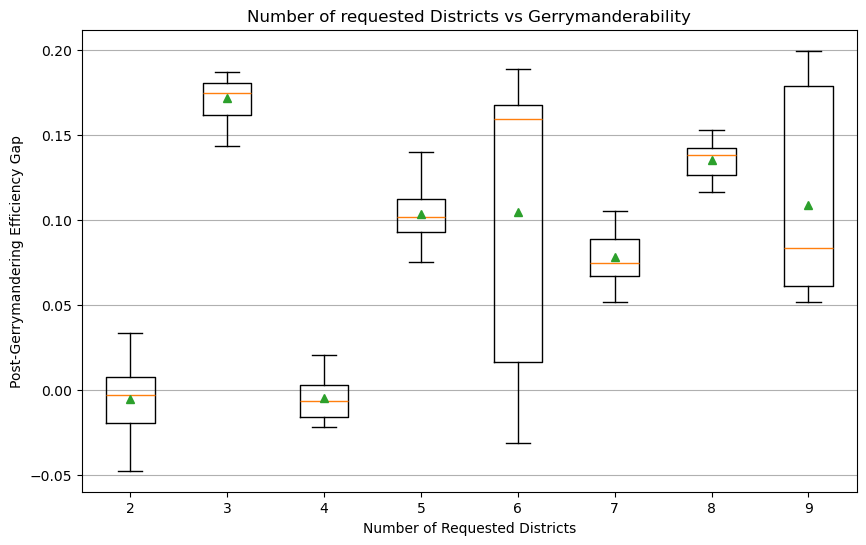

In [25]:
def remove_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return [x for x in data if lower_bound <= x <= upper_bound]

# Prepare data for box plot
num_districts = sorted(runs.keys())  # Ensure sorted order of epsilon
blurred_values = [remove_outliers(runs[nd]['blurred']) for nd in num_districts]

# Create the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(blurred_values, tick_labels=num_districts, showmeans=True)

# Add labels and title
plt.xlabel('Number of Requested Districts')
plt.ylabel('Post-Gerrymandering Efficiency Gap')
plt.title('Number of requested Districts vs Gerrymanderability')
plt.grid(axis='y')

# Show the plot
plt.savefig('impact-of-num-districts.png', dpi=600)
plt.show()

## Q3: Impact of connectedness on Results

In [26]:
total_pop = 1_000_000
total_democrats = total_pop // 2
epsilon = 0.01
num_districts = 10

def gen_blurred_tree(tree, epsilon): 
    ret = copy.deepcopy(tree)
    dg.blur_census_data(ret, epsilon)
    return ret

def gerrymander_tree(tree, num_districts): 
    tree.subtree_to_csv(adjacency_outfile=adj_file, 
                        hierarchy_outfile=hier_file, 
                        demographic_outfile=demo_file)
    districts = gerry.gerrymander(adj_file, demo_file, hier_file, num_districts, 'D')
    return districts

def gen_egap_score(tree, epsilon): 
    districts = gerrymander_tree(tree, num_districts)
    egap, _ = metrics.efficiency_gap(tree, districts)
    return egap

runs = {}
for connectedness in [(0.1, 0.3), (0.3, 0.5), (0.5, 0.7), (0.7, 0.9)]: 
    raw_scores = []
    blurred_scores = []

    for _ in range(25): 
        raw_tree = dg.run_mock_census(num_layers=3, fanout=5, total_pop=total_pop, total_jerries=total_democrats, adj_interval=connectedness)
        raw_egap = gen_egap_score(raw_tree, epsilon)

        blurred_tree = gen_blurred_tree(raw_tree, epsilon)
        districts = gerrymander_tree(blurred_tree, num_districts)
        # measure how well we obfuscated against the _raw_ data. 
        blurred_egap, _ = metrics.efficiency_gap(raw_tree, districts)

        raw_scores.append(raw_egap)
        blurred_scores.append(blurred_egap)
    runs[str(connectedness)] = { 'raw': raw_scores, 'blurred': blurred_scores }

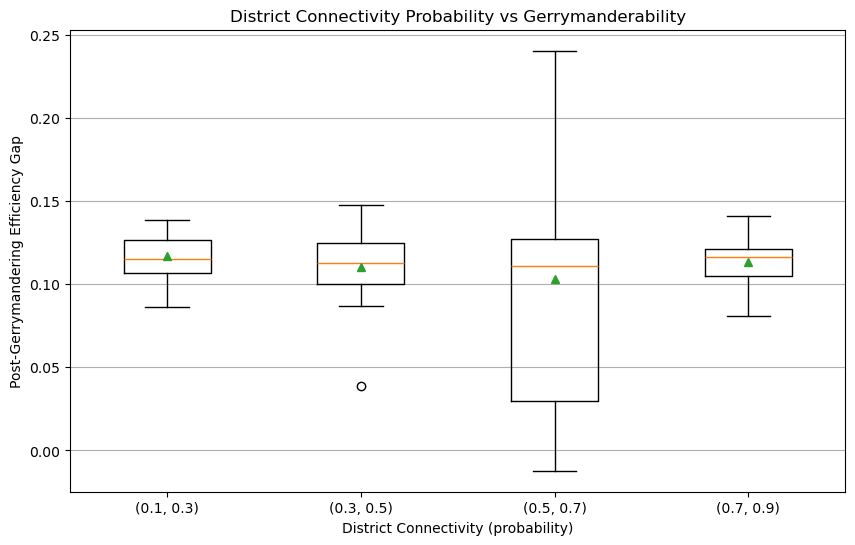

In [27]:
def remove_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return [x for x in data if lower_bound <= x <= upper_bound]

# Prepare data for box plot
num_districts = sorted(runs.keys())  # Ensure sorted order of epsilon
blurred_values = [remove_outliers(runs[nd]['blurred']) for nd in num_districts]

# Create the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(blurred_values, tick_labels=num_districts, showmeans=True)

# Add labels and title
plt.xlabel('District Connectivity (probability)')
plt.ylabel('Post-Gerrymandering Efficiency Gap')
plt.title('District Connectivity Probability vs Gerrymanderability')
plt.grid(axis='y')

# Show the plot
plt.savefig('impact-of-connectivity-districts.png', dpi=600)
plt.show()